<a href="https://colab.research.google.com/github/MatSpad/Advanced-Coding-for-Data-Analytics-Project-2024/blob/main/ACfDA_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Coding for Data Analytics Project
30/04/24
### Group:
Federico De Marinis (267511)

Eleonora Di Mario (275551)

Matteo Spadaccia (277141)

## Introduction
TODO: Intro to the topic and aims of the project

## Part 0 - Preliminary code
In this section, the contextual basis for the analysis is set.

### 0.1 - Importing libraries and functions
Some libraries and functions are imported to ease the specified following tasks.

In [6]:
# [Code: 1]

# Importing libraries               > Useful for:
import os                           # managing directories
import shutil                       # deleting directories
import time                         # checking code run times
from tqdm.auto import tqdm          # generating fancy progress bars
import gzip                         # decompressing and reading .gz files
import networkx as nx               # generating and analyzing graph objects
import pandas as pd                 # managing dataframes
import numpy as np                  # managing arrays
import pickle                       # storing objects (e.g., NetworkX graphs) as binary files
import matplotlib.pyplot as plt     # managing image-format visual representations
import matplotlib.image as mpimg    # reading image-format files
import random                       # random selections

# Importing functions                               > Useful for:
from Functions.section import section               # clearly depicting sections of output
from Functions.mdgJaccard import mdgJaccard         # computing a Jaccard-styled similarity index between node couples in a NetworkX multiDiGraph
from Functions.patientRand import patientRand       # generating a simulated medical patient profile
from Functions.chatDOC import chatDOC#, visualizeDOC # analyzing an hypothetical patient situation (suffered symptoms and eventually past diagnoses); graphically visualizing the results

print("Libraries and functions imported!")

Libraries and functions imported!


### 0.2 - Sript settings
Some variables are settable to customize the specified script's behaviors.

In [7]:
# [Code: 2]

# Script settings               > Usage:
reloadRepository = False        # if True, the GitHub repository is loaded again even if already cloned
rebuildGraph = False            # if True, the graph is built again from input data even if already available as saved object
loadDisconnectedNodes = True    # if True, when eventually rebuilding the graph, all the nodes are considered even if not partecipating in any edge
overwriteSavings = True         # if True, saved files are overwrited by newly computed outputs
generateImages = True           # if True, images are generated during code execution

# Checking settings
repositoryLoaded = os.getcwd()[-17:] == 'cloned-repository' # checks if the current working directory is the cloned repository itself
if not rebuildGraph and not os.path.isfile('Outputs/Graph.pickle'):
  rebuildGraph = True
  print("No previously saved graph object found, the network will be constructed again from data.")

print("Script set!")

Script set!


### 0.3 - Colab-GitHub interaction initialization
Colab's working directory is set by loading the project's GitHub repository. If the latter has already been cloned and the reloadRepository variable [Code: 1 - Script settings] is switched to False, the working directory would not be updated.

In [8]:
# [Code: 3]

# Colab-GitHub interaction initialization
if repositoryLoaded and reloadRepository:   # if the repository is already loaded and to be updated, it is discarded
  os.chdir('..')
  shutil.rmtree('cloned-repository')
  repositoryLoaded = False
if not repositoryLoaded:                    # if the repository is to be loaded (or updated), it is cloned from GitHub
  section("Loading repository:")
  ! git clone -l -s https://github.com/MatSpad/Advanced-Coding-for-Data-Analytics-Project-2024.git cloned-repository
  %cd cloned-repository
  section('done')
else:
  print("Using previously loaded repository!")

Loading repository: ____________________________________________________________
c:\Users\matte\Desktop\Advanced-Coding-for-Data-Analytics-Project-2024\cloned-repository
__________________________________________________________________________ DONE!




Cloning into 'cloned-repository'...
c:\Users\matte\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Part 1 - Constructing the biomedical knowledge graph
In this section, the nodes and edges data are imported and saved as a NetworkX directed multi-graph, on which specific analysis could be run afterwards.

### 1.1 - Building Dataframes from files
The information contained in both the nodelist and edgelist files are loaded as separate Pandas dataframes.

In [9]:
# [Code: 4]

# Bulding nodes dataframe from the related file
section("Loading nodes' info as dataframe:")
nodesDF = pd.read_csv('Inputs/hetionet-v1.0-nodes.tsv',sep='\t')
display(nodesDF)
section('done')

# Bulding edges dataframe from the related file
section("Loading edges list as dataframe:")
edgesDF = pd.read_csv('Inputs/hetionet-v1.0-edges.sif.gz', compression='gzip', sep='\t')
display(edgesDF)
section('done')

Loading nodes' info as dataframe: ______________________________________________


,id,name,kind
0,Anatomy::UBERON:0000002,uterine cervix,Anatomy
1,Anatomy::UBERON:0000004,nose,Anatomy
2,Anatomy::UBERON:0000006,islet of Langerhans,Anatomy
3,Anatomy::UBERON:0000007,pituitary gland,Anatomy
4,Anatomy::UBERON:0000010,peripheral nervous system,Anatomy
...,...,...,...
47026,Symptom::D064250,Hypertriglyceridemic Waist,Symptom
47027,Symptom::D065634,Cerebrospinal Fluid Leak,Symptom
47028,Symptom::D065635,Benign Paroxysmal Positional Vertigo,Symptom
47029,Symptom::D065906,Hyperlactatemia,Symptom


__________________________________________________________________________ DONE!


Loading edges list as dataframe: _______________________________________________


,source,metaedge,target
0,Gene::9021,GpBP,Biological Process::GO:0071357
1,Gene::51676,GpBP,Biological Process::GO:0098780
2,Gene::19,GpBP,Biological Process::GO:0055088
3,Gene::3176,GpBP,Biological Process::GO:0010243
4,Gene::3039,GpBP,Biological Process::GO:0006898
...,...,...,...
2250192,Anatomy::UBERON:0000057,AeG,Gene::65009
2250193,Anatomy::UBERON:0000474,AeG,Gene::80279
2250194,Anatomy::UBERON:0002048,AeG,Gene::1211
2250195,Anatomy::UBERON:0002048,AeG,Gene::8843


__________________________________________________________________________ DONE!




### 1.2 - Preliminary analysis
Some preliminary checks are enacted on the dataframes in order to determine which type of graph could better store the given data (i.e., a directed multigraph).

In [14]:
# [Code: 5]

# Nodes DF preliminary analysis                                                                                                                         > Finding:
section("Nodes dataframe info:")
nodesFileLen = len(nodesDF.index)
uniqueNodeIDs = len(pd.unique(nodesDF['id']))
nodesDF.info()
print("\nNodes in DF:", nodesFileLen, "(of which", uniqueNodeIDs, "different by ID)")                                                                   # the nodes data present 47031 different nodes
check1 = len(nodesDF[nodesDF['kind']=='Symptom']['name'].unique()) == len(nodesDF[nodesDF['kind']=='Symptom'])                                          # symptoms' names (other than IDs) are usable as univocal references
check2 = len(nodesDF[nodesDF['kind']=='Disease']['name'].unique()) == len(nodesDF[nodesDF['kind']=='Disease'])                                          # diseases' names (other than IDs) are usable as univocal references
if check1 and check2:
    print("Symptoms' and diseases' names (other than IDs) are usable as univocal references")
section('end')


# Edges DF preliminary analysis                                                                                                                         > Finding:
section("Edges dataframe info:")
edgesFileLen = len(edgesDF.index)
source_targetCouples = len(edgesDF.loc[:, ['source', 'target']].drop_duplicates())
uniqueEdges = len(edgesDF.drop_duplicates())
edgesDF.info()
print("\nEdges in DF:", edgesFileLen, "\n(of which", uniqueEdges, "different, but just", source_targetCouples, "with different source-target pair)")    # the edges data present 2250197 edges, some with equal source-target pair but different link type
section('end')

Nodes dataframe info: __________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47031 entries, 0 to 47030
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      47031 non-null  object
 1   name    47031 non-null  object
 2   kind    47031 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB

Nodes in DF: 47031 (of which 47031 different by ID)
Symptoms' and diseases' names (other than IDs) are usable as univocal references
________________________________________________________________________________


Edges dataframe info: __________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250197 entries, 0 to 2250196
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   source    object
 1   metaedge  object
 2   target    object
dtypes: object(3)
memory usage: 51.5+ MB

Edges in DF: 2250197 
(of whi

### 1.3 - Constructing the MultiDiGraph
A NetworkX directed multi-graph containing all the nodes' and edges' information is built - and eventually saved overwriting the previous binary file version - or extracted as object from a previously saved file.

In [ ]:
# [Code: 6]

if rebuildGraph:

  # Constructing the MultiDiGRaph by reading the edges file directly (with progress bar)
  '''
  start = time.time()

  section("Loading the graph blending both nodes' and edges' data:")
  G = nx.MultiDiGraph()
  with gzip.open('Inputs/hetionet-v1.0-edges.sif.gz','r') as edgesFile:
    edgesFile.readline()
    for i in tqdm(range(edgesFileLen)):
      lineElements = str(edgesFile.readline())[2:-5].split('\\t')
      G.add_edge(lineElements[0], lineElements[2], edgeType=lineElements[1])
  edgesNum = G.number_of_edges()
  nodesNum = G.number_of_nodes()
  print(edgesNum, nodesNum)
  section("Done")

  end = time.time()
  print(end - start)  # progress-bar-enriched graph building is slightly slower than plain one
  '''

  # Constructing the MultiDiGRaph by reading both the dataframes
  G = nx.from_pandas_edgelist(edgesDF, 'source', 'target', edge_attr='metaedge', create_using=nx.MultiDiGraph())
  edgesNum = G.number_of_edges()
  connectedNodesNum = G.number_of_nodes()

  # Eventually adding disconnected nodes too
  if loadDisconnectedNodes:
    G.add_nodes_from(nodesDF['id'])
    consideredNodesDF = nodesDF
  else:
    consideredNodesDF = nodesDF[nodesDF['id'].isin(G.nodes())]
  nodesNum = G.number_of_nodes()

  # Setting all nodes' attributes
  nx.set_node_attributes(G, {node['id']:{'name':node['name'],'kind':node['kind']} for (i,node) in consideredNodesDF.iterrows()})

  # Saving the graph object to file
  if overwriteSavings:
    pickle.dump(G, open('Outputs/Graph.pickle', 'wb'))
    print("MultiDiGraph built and saved!")
  else:
    print("MultiDiGraph built!")

else:
  # Loading the graph object from file
  G = pickle.load(open('Outputs/Graph.pickle', 'rb'))
  print("MultiDiGraph loaded from previously saved file!")

# Displaying the loaded graph's info (TODO: change visualizations using Gephi)
if not rebuildGraph:
  plt.imshow(mpimg.imread('Outputs/Graph_structure.png'))
  plt.show()
print("Number of edges:", edgesNum, "\nNumber of nodes:", nodesNum)
if loadDisconnectedNodes or not rebuildGraph:
  print("(of which", connectedNodesNum, "connected)")

MultiDiGraph built and saved!
Number of edges: 2250197 
Number of nodes: 47031
(of which 45158 connected)


## Part 2 – Analyzing the biomedical knowledge graph:
In this section, a holistic analysis of the generated graph is enacted; particular attention is given to symptom and disease nodes, their inter-type correlation and intra-type similarity.

### 2.1 - Computing some basic indicators
To gain a general understanding of the graph's structure and size, the following metrics are computed:

1) total number of entities for each unique kind;

2) total number of each unique edge type;

3) average in-degree and out-degree for each type of node.

In [ ]:
# [Code: 7]

# (1) Counting the unique IDs for each kind of node
section("Listing the total number of entities for each unique kind:")
entitiesPerKindDF = consideredNodesDF.groupby('kind')['id'].count().reset_index(name='total_nodes')
display(entitiesPerKindDF)
section('done')

# (2) Counting the occurrences of each unique edge type
section("Listing the total number of each unique edge type:")
edgesPerTypeDF = edgesDF.groupby('metaedge').size().reset_index(name='total_edges')
display(edgesPerTypeDF)
section('done')

# (3) Calculating in-degree and out-degree for each node type
section("Computing the average in-degree and out-degree of each node type:")
inDegreesDF = pd.DataFrame(G.in_degree(), columns=['id', 'in_degree'])
outDegreesDF = pd.DataFrame(G.out_degree(), columns=['id', 'out_degree'])
degreeKindDF = consideredNodesDF[['id', 'kind', 'name']].merge(inDegreesDF, on='id').merge(outDegreesDF, on='id')   # merging the information of degrees with the nodesDF to associate each node with its type
averageDegreesPerKind = degreeKindDF.groupby('kind').agg(averageInDegree=('in_degree', 'mean'),averageOutDegree=('out_degree', 'mean')).reset_index()   # grouping by the node type (kind) and calculate the average in-degree and out-degree
display(averageDegreesPerKind)
section('done')

Listing the total number of entities for each unique kind: _____________________


,kind,total_nodes
0,Anatomy,402
1,Biological Process,11381
2,Cellular Component,1391
3,Compound,1552
4,Disease,137
5,Gene,20945
6,Molecular Function,2884
7,Pathway,1822
8,Pharmacologic Class,345
9,Side Effect,5734


__________________________________________________________________________ DONE!


Listing the total number of each unique edge type: _____________________________


,metaedge,total_edges
0,AdG,102240
1,AeG,526407
2,AuG,97848
3,CbG,11571
4,CcSE,138944
5,CdG,21102
6,CpD,390
7,CrC,6486
8,CtD,755
9,CuG,18756


__________________________________________________________________________ DONE!


Computing the average in-degree and out-degree of each node type: ______________


,kind,averageInDegree,averageOutDegree
0,Anatomy,8.960199,1807.201493
1,Biological Process,49.161234,0.000000
2,Cellular Component,52.887132,0.000000
3,Compound,4.842139,127.579897
4,Disease,12.321168,258.970803
5,Gene,61.132824,61.551206
6,Molecular Function,33.710818,0.000000
7,Pathway,46.307355,0.000000
8,Pharmacologic Class,0.000000,2.982609
9,Side Effect,24.231601,0.000000


__________________________________________________________________________ DONE!




### 2.2 - Analyzing diseases-symptoms correlation
1) For each disease-type node the in-degree and out-degree is computed and the most connected diseases are shown.

2) The disease-symptom sub-graph is extracted and the average
number of symptoms related to a disease is computed.

In [ ]:
# [Code: 8]

# (1) Analyzing the degrees of each disease-type node
diseasesDegrees = degreeKindDF[degreeKindDF['kind']=='Disease'].drop(columns='kind')
section("Disease-type nodes with higest in-degrees:")
display(diseasesDegrees.sort_values(by='in_degree', ascending=False).drop(columns='out_degree').head(5))
section('end')
section("Disease-type nodes with higest out-degrees:")
display(diseasesDegrees.sort_values(by='out_degree', ascending=False).drop(columns='in_degree').head(5))
section('end')

# (2) Extracting the disease-symptom sub-graph and computing the symptom/disease ratio
section("Disease-symtpom sub-graph info:")
diseasesSymptomsSubG = G.subgraph(consideredNodesDF[consideredNodesDF['kind'].isin(['Disease', 'Symptom'])]['id'])
edgesTypeDF = edgesDF.merge(consideredNodesDF.rename(columns={'id': 'source'}), on='source').merge(consideredNodesDF.rename(columns={'id': 'target'}), on='target')
edgesTypeDF = edgesTypeDF.rename(columns={'kind_x':'kind_source', 'name_x':'name_source','kind_y':'kind_target','name_y':'name_target'})
edgesDiseasesSymptomsSubDF = edgesTypeDF[edgesTypeDF['kind_source'].isin(['Disease', 'Symptom']) & edgesTypeDF['kind_target'].isin(['Disease', 'Symptom'])]
print("Type of edges:", edgesDiseasesSymptomsSubDF['metaedge'].unique())  # Asserting disease-to-symptom as only direction for disease-symptom edges
symptomDiseaseRatio = len(edgesDiseasesSymptomsSubDF[edgesDiseasesSymptomsSubDF['metaedge']=='DpS'])/len(consideredNodesDF[consideredNodesDF['kind']=='Disease'])
print("Average number of symptoms related to each disease:", symptomDiseaseRatio)
section('end')

Disease-type nodes with higest in-degrees: _____________________________________


,id,name,in_degree
14739,Disease::DOID:10763,hypertension,73
14804,Disease::DOID:2531,hematologic cancer,53
14784,Disease::DOID:1612,breast cancer,44
14807,Disease::DOID:2841,asthma,41
14818,Disease::DOID:3393,coronary artery disease,40


________________________________________________________________________________


Disease-type nodes with higest out-degrees: ____________________________________


,id,name,out_degree
14784,Disease::DOID:1612,breast cancer,1115
14804,Disease::DOID:2531,hematologic cancer,1076
14808,Disease::DOID:2986,IgA glomerulonephritis,966
14793,Disease::DOID:1909,melanoma,931
14842,Disease::DOID:7148,rheumatoid arthritis,868


________________________________________________________________________________


Disease-symtpom sub-graph info: ________________________________________________
Type of edges: ['DrD' 'DpS']
Average number of symptoms related to each disease: 24.503649635036496
________________________________________________________________________________




### 2.3 - Computing diseases' and symptoms' similarity
TODO...

In [ ]:
# [Code: 9]

# TODO: description, tidily presenting outputs
undirectedG = nx.Graph(G)
print(undirectedG.number_of_edges(), G.number_of_edges())                                               # TODO: explain finding

idDiabete1 = consideredNodesDF[consideredNodesDF['name']=='type 1 diabetes mellitus'][consideredNodesDF['kind']=='Disease']['id'].iloc[0]
idDiabete2 = consideredNodesDF[consideredNodesDF['name']=='type 2 diabetes mellitus'][consideredNodesDF['kind']=='Disease']['id'].iloc[0]
jaccardDiabetes = next(nx.jaccard_coefficient(undirectedG, [(idDiabete1, idDiabete2)]))
print(jaccardDiabetes)                                                                                  # TODO: explain finding

idEyePain = consideredNodesDF[consideredNodesDF['name']=='Eye Pain'][consideredNodesDF['kind']=='Symptom']['id'].iloc[0]
idBlindness = consideredNodesDF[consideredNodesDF['name']=='Blindness'][consideredNodesDF['kind']=='Symptom']['id'].iloc[0]
jaccardEyeDiseases = next(nx.jaccard_coefficient(undirectedG, [(idEyePain, idBlindness)]))
print(jaccardEyeDiseases)                                                                               # TODO: explain finding

# TODO: describing the usage of our Jaccard-computation function, tidily presenting outputs
print(mdgJaccard(G, idDiabete1, idDiabete2))
print(mdgJaccard(G, idEyePain, idBlindness))

print(next(nx.jaccard_coefficient(undirectedG, [('Gene::5743', 'Gene::3725')])))
print(mdgJaccard(G, 'Gene::5743', 'Gene::3725'))

2107709 2250197
('Disease::DOID:9744', 'Disease::DOID:9352', 0.13267326732673268)
('Symptom::D058447', 'Symptom::D001766', 0.35)
0.13267326732673268
0.35
('Gene::5743', 'Gene::3725', 0.10552763819095477)
0.09482758620689655


<ipython-input-11-5d5a47e693da>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idDiabete1 = consideredNodesDF[consideredNodesDF['name']=='type 1 diabetes mellitus'][consideredNodesDF['kind']=='Disease']['id'].iloc[0]
<ipython-input-11-5d5a47e693da>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idDiabete2 = consideredNodesDF[consideredNodesDF['name']=='type 2 diabetes mellitus'][consideredNodesDF['kind']=='Disease']['id'].iloc[0]
<ipython-input-11-5d5a47e693da>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idEyePain = consideredNodesDF[consideredNodesDF['name']=='Eye Pain'][consideredNodesDF['kind']=='Symptom']['id'].iloc[0]
<ipython-input-11-5d5a47e693da>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idBlindness = consideredNodesDF[consideredNodesDF['name']=='Blindness'][consideredNodesDF['kind']=='Symptom']['id'].iloc[0]


## Part 3 - Treating an immaginary patient
In this section, TODO: suppose you have an imaginary patient with one symptom (of your choice). Try to help
them with some data analysis (e.g., study the possible diseases, select the disease, the
gene, the possible compounds, the side effects, try to mitigate side effects, and so
on...)

Hypoteses:
- The patient start talking to chatDOC recognizing of one and only one main symptom
- The patient is eventually also aware of other secondary symptoms (which may be uncorrelated with the main one and thus not considered to obtain the final diagnosis) and already diagnosed diseases
- The patient has one and only one disease to be diagnosed, if no significant symptoms are recognized which are not correlated to an already diagnosed disease, that diagnosis will be just confirmed.
---
- Disease-to-symptom edges mean that the particular disease necessarily implies the appeareance of all the connected symptoms (while not viceversa), thus the main symptoms are considered to be the ones triggered by a lower number of different diseases
- Compound-to-disease edges mean that the particular compound perfectly treats (at the same exact extent as all the other compounds connected to that disease node) the specific illness
- Compound-to-side-effect edges mean that the particular compound eventually casues the appearance of that specific side effect with an undefined constant probability, thus (being all side effects comparable by severeness) the best compound for a disease is determinable as the connected one with fewer possible side effects
- Disease-to-anatomy edges mean that the particular disease could affect the specific anatomy, thus the main anatomies are considered to be the ones affectable by a lower number of different diseases
- Disease-to-diseases edges connect pairs of diseases that could probably appear together in a patient, thus (if no univocal diagnosis is obtainable based on observed symptoms olny) eventually multiple possible diagnosis are ordered based on their eventual connections with already diagnosed diseases

TODO: verificare la verosomiglianza delle ipotesi confrontando la descrizione dei metaedge nella repository d'origine degli input, riportarne le informazioni significative nel readme degli input della nostra repository.

Graph representing all the possible types of connections among the different node kinds: 


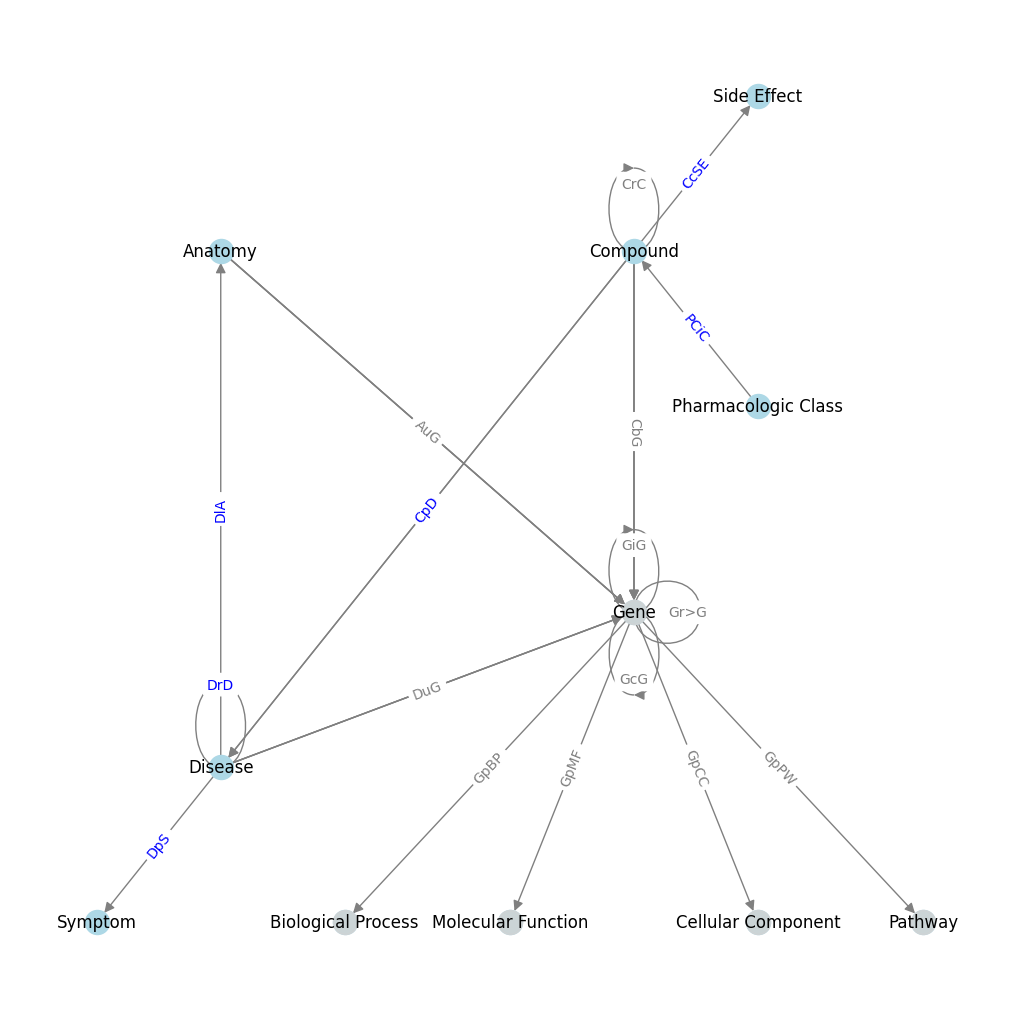

________________________________________________________________________________




In [ ]:
# [Code: 10]

# Building the graph representing all the possible types of connections among the different node kinds
connectionTypeDF = edgesTypeDF[['metaedge','kind_source','kind_target']].drop_duplicates()
recapConnectionsG =  nx.from_pandas_edgelist(connectionTypeDF, 'kind_source', 'kind_target', edge_attr='metaedge', create_using=nx.MultiDiGraph())

# Drawing the graph with nodes and edges
if generateImages:
  plt.figure(figsize=(10, 10))
  pos = {'Gene':[0.5,-0.2],
         'Biological Process':[-0.2,-0.8],
         'Compound':[0.5,0.5],
         'Anatomy':[-0.5,0.5],
         'Disease':[-0.5,-0.5],
         'Molecular Function':[0.2,-0.8],
         'Pathway':[1.2,-0.8],
         'Cellular Component':[0.8,-0.8],
         'Pharmacologic Class':[0.8,0.2],
         'Side Effect':[ 0.8, 0.8],
         'Symptom':[ -0.8, -0.8]} # customized positions for all nodes
  nx.draw(recapConnectionsG, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrowstyle='-|>', arrowsize=15)
  unusedNodes = ['Gene', 'Biological Process', 'Cellular Component', 'Molecular Function', 'Pathway']
  nx.draw_networkx_nodes(recapConnectionsG, pos, nodelist=unusedNodes, node_color='lightgrey', alpha=0.8)
  usedEdges = {edge:metaedge for edge,metaedge in nx.get_edge_attributes(recapConnectionsG, 'metaedge').items() if metaedge in ['DpS', 'DrD', 'DlA', 'CpD', 'CcSE', 'PCiC']}
  unusedEdges = {edge:metaedge for edge,metaedge in nx.get_edge_attributes(recapConnectionsG, 'metaedge').items() if metaedge in ['AuG', 'DuG', 'CbG', 'GpBP', 'GpMF', 'GpCC', 'GpPW', 'CrC', 'GiG', 'GcG', 'Gr>G']}
  usedEdgeLabels = nx.draw_networkx_edge_labels(recapConnectionsG, pos, edge_labels=usedEdges ,  font_color='blue')
  unusedEdgeLabels = nx.draw_networkx_edge_labels(recapConnectionsG, pos, edge_labels=unusedEdges ,  font_color='grey')
  if overwriteSavings:
    plt.savefig('Outputs/Graph_structure.png', dpi=300, bbox_inches='tight')
  section("Graph representing all the possible types of connections among the different node kinds:")
  plt.show()
  section('end')

In [ ]:
patient = patientRand(G,3,2,1)
output = chatDOC(G,patient[0])
print(patient)
print(output)

# VISUALIZATON function(G,output):
# Paziente:  symptoms (sbiaditi quelli irrilevanti), diseases (sbiadite quelle totalmente rilevanti)
# Diagnosi:  diagnosis, top3 additional symptoms, top3 anatomies, best compound + numOfAlternatives + numOfSideEffects + phClass (or eventually just possible diseases)

# Nota: a volte la diagnosi univoca trovata da chatDOC è solo la conferma di una delle malattie già diagnosticate che il paziente porta in input,
#       in tal caso la visualizzazione può mantenere lo stesso schema e la malattia deve comparire come rilevante sia nella sezione paziente (a sx) sia come diagnosi (a dx),
#       possibilmente con un collegamento più vistoso di quello tra relevant diseases e diagnosi.
#       Per questo motivo diagnosisSymtoms (contenente tutti i sintomi dovuti alla malattia diagnosticata, anche se già riscontrati dal paziente) è stato aggiunto all'output di chatDOC:
#       nel suddetto caso, andrà visualizzata (con nota annessa) la top-3 dei sintomi connessi alla diagnosi anziché quella dei sintomi AGGIUNTI dovuti alla diagnosi (che risulterebbe vuota).

({'symptoms': ['Symptom::D020324', 'Symptom::D002558', 'Symptom::D006314', 'Symptom::D008607', 'Symptom::D001832'], 'diseases': ['Disease::DOID:13378']}, {'Disease::DOID:2994'})
{'symptoms': ['Symptom::D020324', 'Symptom::D002558', 'Symptom::D006314', 'Symptom::D008607', 'Symptom::D001832'], 'diseases': ['Disease::DOID:13378'], 'diseasesAdditionalSymptoms': ['Symptom::D054078', 'Symptom::D000787', 'Symptom::D011695', 'Symptom::D006337', 'Symptom::D011696', 'Symptom::D007565', 'Symptom::D005158', 'Symptom::D006319', 'Symptom::D005335', 'Symptom::D005334', 'Symptom::D015746', 'Symptom::D004487'], 'relevantSymptoms': ['Symptom::D020324', 'Symptom::D002558', 'Symptom::D006314', 'Symptom::D006337', 'Symptom::D005158', 'Symptom::D006319', 'Symptom::D005334', 'Symptom::D015746', 'Symptom::D004487'], 'irrelevantSymptoms': ['Symptom::D008607', 'Symptom::D001832', 'Symptom::D054078', 'Symptom::D000787', 'Symptom::D011695', 'Symptom::D011696', 'Symptom::D007565', 'Symptom::D005335'], 'unrecognize

# Visualization function

ValueError: 'c' argument has 12 elements, which is inconsistent with 'x' and 'y' with size 15.

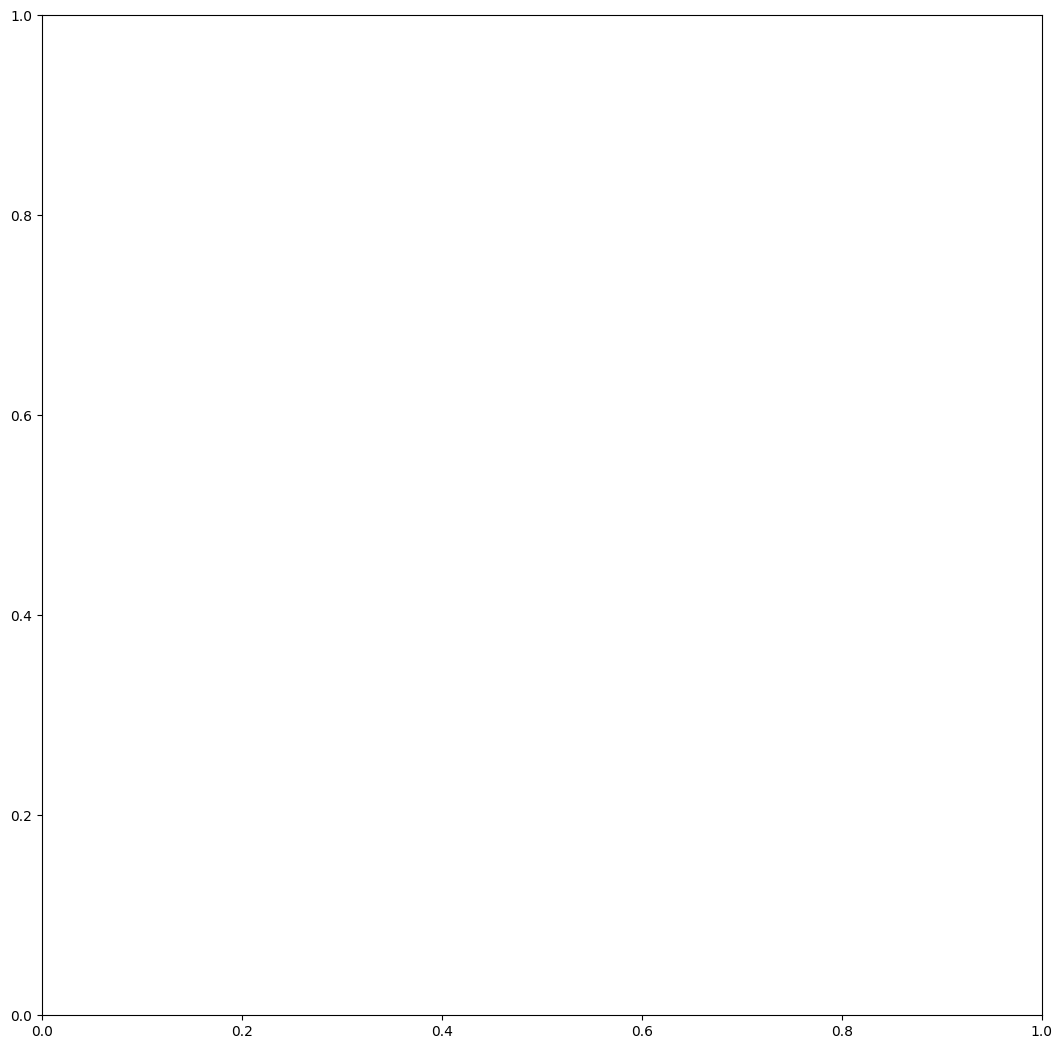

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd



output1 = {'symptoms': ['Symptom::D053201', 'Symptom::D059373', 'Symptom::D010264', 'Symptom::D002385', 'Symptom::D037061'],
          'diseases': ['Disease::DOID:216'],
          'diseasesAdditionalSymptoms': ['Symptom::D005884', 'Symptom::D006209', 'Symptom::D012415', 'Symptom::D013851', 'Symptom::D014098', 'Symptom::D009058', 'Symptom::D006472', 'Symptom::D013651', 'Symptom::D050177', 'Symptom::D014313', 'Symptom::D002032', 'Symptom::D005183', 'Symptom::D001724', 'Symptom::D009912', 'Symptom::D005157', 'Symptom::D008607', 'Symptom::D004314', 'Symptom::D001835'],
          'relevantSymptoms': ['Symptom::D053201', 'Symptom::D059373', 'Symptom::D010264'],
          'irrelevantSymptoms': ['Symptom::D002385', 'Symptom::D037061', 'Symptom::D005884', 'Symptom::D006209', 'Symptom::D012415', 'Symptom::D013851', 'Symptom::D014098', 'Symptom::D009058', 'Symptom::D006472', 'Symptom::D013651', 'Symptom::D050177', 'Symptom::D014313', 'Symptom::D002032', 'Symptom::D005183', 'Symptom::D001724', 'Symptom::D009912', 'Symptom::D005157', 'Symptom::D008607', 'Symptom::D004314', 'Symptom::D001835'],
          'unrecognizedSymptoms': [],
          'relevantDiseases': set(),
          'irrelevantDiseases': {'Disease::DOID:216'},
          'unrecognizedDiseases': [],

          'possibleDiseases': None,

          'diagnosis': 'Disease::DOID:10283',
          'diagnosisSymptoms': ['Symptom::D060545', 'Symptom::D053448', 'Symptom::D059373', 'Symptom::D059226', 'Symptom::D053158', 'Symptom::D019584', 'Symptom::D059411', 'Symptom::D005262', 'Symptom::D053159', 'Symptom::D053201', 'Symptom::D014550', 'Symptom::D005414', 'Symptom::D005483', 'Symptom::D014549', 'Symptom::D017699', 'Symptom::D010148', 'Symptom::D003248', 'Symptom::D010264', 'Symptom::D000860', 'Symptom::D005221', 'Symptom::D010149', 'Symptom::D003967', 'Symptom::D009325', 'Symptom::D010146', 'Symptom::D004487'],
          'additionalSymptoms': ['Symptom::D060545', 'Symptom::D053448', 'Symptom::D059226', 'Symptom::D053158', 'Symptom::D019584', 'Symptom::D059411', 'Symptom::D005262', 'Symptom::D053159', 'Symptom::D014550', 'Symptom::D005414', 'Symptom::D005483', 'Symptom::D014549', 'Symptom::D017699', 'Symptom::D010148', 'Symptom::D003248', 'Symptom::D000860', 'Symptom::D005221', 'Symptom::D010149', 'Symptom::D003967', 'Symptom::D009325', 'Symptom::D010146', 'Symptom::D004487'],
          'anatomies': ['Anatomy::UBERON:0002366', 'Anatomy::UBERON:0002367', 'Anatomy::UBERON:0000999', 'Anatomy::UBERON:0001000', 'Anatomy::UBERON:0000998', 'Anatomy::UBERON:0001968', 'Anatomy::UBERON:0000057', 'Anatomy::UBERON:0001008', 'Anatomy::UBERON:0000473', 'Anatomy::UBERON:0000989', 'Anatomy::UBERON:0000056', 'Anatomy::UBERON:0002481', 'Anatomy::UBERON:0002356', 'Anatomy::UBERON:0002371', 'Anatomy::UBERON:0001088', 'Anatomy::UBERON:0000029', 'Anatomy::UBERON:0000483'],
          'compounds_sideEffectsNum': [('Compound::DB00126', 0), ('Compound::DB01196', 66), ('Compound::DB05812', 71), ('Compound::DB00655', 74), ('Compound::DB00665', 89), ('Compound::DB00499', 90), ('Compound::DB08866', 104), ('Compound::DB06699', 118), ('Compound::DB01233', 118), ('Compound::DB00706', 118), ('Compound::DB06772', 137), ('Compound::DB00773', 153), ('Compound::DB00977', 153), ('Compound::DB01204', 177), ('Compound::DB01128', 201), ('Compound::DB00741', 231), ('Compound::DB00014', 249), ('Compound::DB00443', 249), ('Compound::DB01234', 249), ('Compound::DB00286', 255), ('Compound::DB00635', 258), ('Compound::DB01248', 297), ('Compound::DB00736', 302), ('Compound::DB00338', 302), ('Compound::DB00482', 344), ('Compound::DB00783', 445), ('Compound::DB01101', 483), ('Compound::DB00445', 511), ('Compound::DB00997', 511), ('Compound::DB00813', 521)],
          'bestCompoundPharmacologicClasses': []}

def visualization(output):

  singleDisease = output['possibleDiseases'] is None
  compoundExistence = output['compounds_sideEffectsNum'] != []

  plt.show()

  V = nx.DiGraph()

  # Extract data from the output (dictionary)
  # base case
  patientSymptoms = output['symptoms']
  patientDiseases = output['diseases']
  patientIrrelevantSymptoms = output['irrelevantSymptoms']
  patientIrrelevantDiseases = output['irrelevantDiseases']
  if singleDisease:
    diagnosisNodes = output['diagnosis']
    if compoundExistence:
      compoundInfo = output['compounds_sideEffectsNum'][0]
    topAnatomies = output['anatomies'][:min(3, len(output['anatomies']))]
    additionalSymptoms = output['additionalSymptoms'][:min(3, len(output['additionalSymptoms']))]
  else:
    diagnosisNodes = 'diagnoses'
  # no disease found

  posPatient = {}
  posDiagnosis = {}

  # DIAGNOSIS
  # one disease found
  if singleDisease:
    V.add_node(diagnosisNodes, color='lightpink', type='diagnosis', label=diagnosisNodes, size = 4000) # pos solo di esempio #forse questo
    posDiagnosis[diagnosisNodes] = (0, 0)

    # nodes for diagnosis (symptoms, compound, and anatomies)
    x = 0
    for symp in additionalSymptoms:
      V.add_node(symp, color='lightpink', type='diagnosis')
      V.add_edge(diagnosisNodes, symp)
      posDiagnosis[symp] = (x, 1)
      x += 0.5

    # Add anatomy nodes
    x = 0
    for anatomy in topAnatomies:
      V.add_node(anatomy, color='lightpink', type='anatomy')
      V.add_edge(diagnosisNodes, anatomy)
      posDiagnosis[anatomy] = (x, -1)
      x += 0.5


    # compound node and info
    if compoundExistence:
      compoundNode, sideEffectsCount = compoundInfo
      if output['bestCompoundPharmacologicClasses']:
        pharmacologicClass = output['bestCompoundPharmacologicClasses'][0]
        V.add_node(compoundNode, color='lightpink', type='diagnosis',
                    label=f"Compound: {compoundNode}\nPharmacological class: {pharmacologicClass}\nNumber of side effects: {sideEffectsCount}\nNumber of alternatives: {len(output['compounds_sideEffectsNum'])}")#forse questo
        V.add_edge(diagnosisNodes, compoundNode)
        posDiagnosis[compoundNode] = (1, 0)
      else:
        V.add_node(compoundNode, color='lightpink', type='diagnosis',
                    label=f"Compound: {compoundNode}\nNumber of side effects: {sideEffectsCount}\nNumber of alternatives: {len(output['compounds_sideEffectsNum'])}")#forse questo
        V.add_edge(diagnosisNodes, compoundNode)
        posDiagnosis[compoundNode] = (1, 0)

  # POSSIBLE DISEASES
  # many possible diagnosis
  if not singleDisease:
    V.add_node(diagnosisNodes, color='lightpink', type='diagnosis', label=diagnosisNodes, size = 4000) # pos solo di esempio# forse questo
    posDiagnosis[diagnosisNodes] = (0, 0)

  # PATIENT
  # symptoms
  increment = 2/(len(patientSymptoms+patientDiseases)-1)
  y = 1
  for symp in patientSymptoms:
    if symp not in patientIrrelevantSymptoms:
      V.add_node(symp, color='lightgreen', type='patient')
      V.add_edge(diagnosisNodes, symp)
      posPatient[symp] = (-1, y)
      y += -increment
    else:
      V.add_node(symp, color='lightgrey', type='patient')
      posPatient[symp] = (-1, y)
      y += -increment
#  patientDiseases.reverse()

  y = -1
  for disease in patientDiseases:
    V.add_node(disease, color='lightpink' if disease not in patientIrrelevantDiseases else 'lightgrey', type='patient')
    posPatient[disease] = (-1, y)
    y += increment

    # if disease is relevant and  different from diagnosis
    if disease not in patientIrrelevantDiseases and disease != diagnosisNodes:
      V.add_edge(diagnosisNodes, disease)
    # if disease is relevant and equal to the diagnosis
    elif disease not in patientIrrelevantDiseases and disease == diagnosisNodes:
      V.add_edge(diagnosisNodes, disease, color='lightpink', width=4.0)


  # Draw the graph
  pos = {**posPatient,**posDiagnosis}
  colors = [V.nodes[node].get('color', 'grey') for node in V]
  labels = {node: V.nodes[node].get('label', node) for node in V}
  sizes = [V.nodes[node].get('size', 500) for node in V]

  edges = V.edges(data=True)
  colors = [edge[2].get('color', 'black') for edge in edges]
  widths = [edge[2].get('width', 1.0) for edge in edges]


  plt.figure(figsize=(10, 10))
  nx.draw(V, pos, node_color=colors, node_size=sizes, with_labels=False, arrowstyle='-|>', arrowsize=15)


#  label_pos = {node: (coordinates[0], coordinates[1] + 0.03) for node, coordinates in pos.items()}
#  nx.draw_networkx_labels(V, label_pos, labels)

  # Disegna le etichette dei nodi usando la posizione aggiustata per tutte le etichette
  for node, (x, y) in pos.items():
    if node == diagnosisNodes:
      plt.text(x, y - 0.04, node, fontsize=12, ha='center', va='center')
    elif node in topAnatomies:
      plt.text(x, y - 0.1, labels[node], fontsize=12, ha='center', va='bottom')#forse questo
    else:
      plt.text(x, y + 0.06, node, fontsize=12, ha='center', va='center')
    if compoundExistence:
      if node == compoundNode:
        plt.text(x + 0.04, y, labels[node], fontsize=12, ha='left', va='center')#forse questo


patient = patientRand(G,4,1,2)
output = chatDOC(G,patient[0])
visualization(output)
print(output)

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random

def visualization(output):
    V = nx.DiGraph()
      # Extract data from the output (dictionary)
  # base case
  patientSymptoms = output['symptoms']
  patientDiseases = output['diseases']
  patientIrrelevantSymptoms = output['irrelevantSymptoms']
  patientIrrelevantDiseases = output['irrelevantDiseases']
  if singleDisease:
    diagnosisNodes = output['diagnosis']
    if compoundExistence:
      compoundInfo = output['compounds_sideEffectsNum'][0]
    topAnatomies = output['anatomies'][:min(3, len(output['anatomies']))]
    additionalSymptoms = output['additionalSymptoms'][:min(3, len(output['additionalSymptoms']))]
  else:
    diagnosisNodes = 'diagnoses'
  # no disease found



    # Positioning for patient and diagnosis
    posPatient = {}
    posDiagnosis = {}

    # DIAGNOSIS
  # one disease found
  if singleDisease:
    V.add_node(diagnosisNodes, color='lightpink', type='diagnosis', label=diagnosisNodes, size = 4000) # pos solo di esempio #forse questo
    posDiagnosis[diagnosisNodes] = (0, 0)

    # nodes for diagnosis (symptoms, compound, and anatomies)
    x = 0
    for symp in additionalSymptoms:
      V.add_node(symp, color='lightpink', type='diagnosis')
      V.add_edge(diagnosisNodes, symp)
      posDiagnosis[symp] = (x, 1)
      x += 0.5

    # Add anatomy nodes
    x = 0
    for anatomy in topAnatomies:
      V.add_node(anatomy, color='lightpink', type='anatomy')
      V.add_edge(diagnosisNodes, anatomy)
      posDiagnosis[anatomy] = (x, -1)
      x += 0.5


    # compound node and info
    if compoundExistence:
      compoundNode, sideEffectsCount = compoundInfo
      if output['bestCompoundPharmacologicClasses']:
        pharmacologicClass = output['bestCompoundPharmacologicClasses'][0]
        V.add_node(compoundNode, color='lightpink', type='diagnosis',
                    label=f"Compound: {compoundNode}\nPharmacological class: {pharmacologicClass}\nNumber of side effects: {sideEffectsCount}\nNumber of alternatives: {len(output['compounds_sideEffectsNum'])}")#forse questo
        V.add_edge(diagnosisNodes, compoundNode)
        posDiagnosis[compoundNode] = (1, 0)
      else:
        V.add_node(compoundNode, color='lightpink', type='diagnosis',
                    label=f"Compound: {compoundNode}\nNumber of side effects: {sideEffectsCount}\nNumber of alternatives: {len(output['compounds_sideEffectsNum'])}")#forse questo
        V.add_edge(diagnosisNodes, compoundNode)
        posDiagnosis[compoundNode] = (1, 0)

  # POSSIBLE DISEASES
  # many possible diagnosis
  if not singleDisease:
    V.add_node(diagnosisNodes, color='lightpink', type='diagnosis', label=diagnosisNodes, size = 4000) # pos solo di esempio# forse questo
    posDiagnosis[diagnosisNodes] = (0, 0)

  # PATIENT
  # symptoms
  increment = 2/(len(patientSymptoms+patientDiseases)-1)
  y = 1
  for symp in patientSymptoms:
    if symp not in patientIrrelevantSymptoms:
      V.add_node(symp, color='lightgreen', type='patient')
      V.add_edge(diagnosisNodes, symp)
      posPatient[symp] = (-1, y)
      y += -increment
    else:
      V.add_node(symp, color='lightgrey', type='patient')
      posPatient[symp] = (-1, y)
      y += -increment
#  patientDiseases.reverse()

  y = -1
  for disease in patientDiseases:
    V.add_node(disease, color='lightpink' if disease not in patientIrrelevantDiseases else 'lightgrey', type='patient')
    posPatient[disease] = (-1, y)
    y += increment

    # if disease is relevant and  different from diagnosis
    if disease not in patientIrrelevantDiseases and disease != diagnosisNodes:
      V.add_edge(diagnosisNodes, disease)
    # if disease is relevant and equal to the diagnosis
    elif disease not in patientIrrelevantDiseases and disease == diagnosisNodes:
      V.add_edge(diagnosisNodes, disease, color='lightpink', width=4.0)


    # Nodes positioning
    pos = {**posPatient, **posDiagnosis}

    # Nodes colors and sizes
    node_colors = [V.nodes[node].get('color', 'grey') for node in V.nodes()]
    node_sizes = [V.nodes[node].get('size', 500) for node in V.nodes()]

    # Drawing the graph
    plt.figure(figsize=(15, 15))
    nx.draw(V, pos, node_color=node_colors, node_size=node_sizes, with_labels=False, arrowstyle='-|>', arrowsize=15)

    # Edge colors and widths for special edges
    edge_colors = ['black' if V.nodes[edge[0]]['color'] == 'lightpink' and V.nodes[edge[1]]['color'] == 'lightpink' else 'black' for edge in V.edges()]
    edge_widths = [2 if V.nodes[edge[0]]['color'] == 'lightpink' and V.nodes[edge[1]]['color'] == 'lightpink' else 1 for edge in V.edges()]

    # Draw edges
    nx.draw_networkx_edges(V, pos, edge_color=edge_colors, width=edge_widths)

    # Edge labels
    edge_labels = {(u, v): 'corresponding' for u, v in V.edges() if V.nodes[u]['color'] == 'lightpink' and V.nodes[v]['color'] == 'lightpink'}
    nx.draw_networkx_edge_labels(V, pos, edge_labels=edge_labels, font_color='red')

    # Draw node labels
    for node, (x, y) in pos.items():
        label = V.nodes[node].get('label', node)
        plt.text(x, y, label, fontsize=12, ha='center', va='center')

    # Display the graph
    plt.axis('off')
    plt.show()

# Mock the patientRand and chatDOC functions
def patientRand(G, s, irrs, d):
    # Your implementation of patientRand...
    return patient, possibleDiseases

def chatDOC(G, patient):
    # Your implementation of chatDOC...
    return output

# Example usage:
patient = patientRand(G, 4, 1, 2)
output = chatDOC(G, patient[0])
visualization(output)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 10)

In [ ]:
testfallito1 = {'symptoms': ['Symptom::D004454', 'Symptom::D006816', 'Symptom::D013342', 'Symptom::D020150', 'Symptom::D012133'], 'diseases': ['Disease::DOID:2377'], 'diseasesAdditionalSymptoms': ['Symptom::D054972', 'Symptom::D054971', 'Symptom::D055955', 'Symptom::D009122', 'Symptom::D000326', 'Symptom::D009222', 'Symptom::D001264', 'Symptom::D053202', 'Symptom::D000370', 'Symptom::D020828', 'Symptom::D005207', 'Symptom::D020336', 'Symptom::D009128', 'Symptom::D005222', 'Symptom::D007035', 'Symptom::D001039', 'Symptom::D014202', 'Symptom::D059411', 'Symptom::D020234', 'Symptom::D009120', 'Symptom::D053201', 'Symptom::D006313', 'Symptom::D006606', 'Symptom::D004411', 'Symptom::D006970', 'Symptom::D003639', 'Symptom::D000381', 'Symptom::D004401', 'Symptom::D013035', 'Symptom::D020078', 'Symptom::D001072', 'Symptom::D003117', 'Symptom::D051346', 'Symptom::D004421', 'Symptom::D006316', 'Symptom::D006423', 'Symptom::D002819', 'Symptom::D020233', 'Symptom::D010468', 'Symptom::D012607', 'Symptom::D006429', 'Symptom::D014717', 'Symptom::D001037', 'Symptom::D008569', 'Symptom::D014549', 'Symptom::D014103', 'Symptom::D004244', 'Symptom::D012021', 'Symptom::D015354', 'Symptom::D001750', 'Symptom::D012678', 'Symptom::D001259', 'Symptom::D009133', 'Symptom::D009437', 'Symptom::D013064', 'Symptom::D002524', 'Symptom::D009886', 'Symptom::D011782', 'Symptom::D006987', 'Symptom::D006311', 'Symptom::D004172', 'Symptom::D014786', 'Symptom::D005158', 'Symptom::D001766', 'Symptom::D012893', 'Symptom::D010291', 'Symptom::D010264', 'Symptom::D003248', 'Symptom::D005132', 'Symptom::D006319', 'Symptom::D005221', 'Symptom::D010292', 'Symptom::D009461', 'Symptom::D018908', 'Symptom::D010243', 'Symptom::D010146'], 'relevantSymptoms': ['Symptom::D004454', 'Symptom::D006816', 'Symptom::D013342', 'Symptom::D004421', 'Symptom::D002819', 'Symptom::D014103', 'Symptom::D012021', 'Symptom::D013064', 'Symptom::D012893'], 'irrelevantSymptoms': ['Symptom::D006816', 'Symptom::D020150', 'Symptom::D012133', 'Symptom::D054972', 'Symptom::D054971', 'Symptom::D055955', 'Symptom::D009122', 'Symptom::D000326', 'Symptom::D009222', 'Symptom::D001264', 'Symptom::D053202', 'Symptom::D000370', 'Symptom::D020828', 'Symptom::D005207', 'Symptom::D020336', 'Symptom::D009128', 'Symptom::D005222', 'Symptom::D007035', 'Symptom::D001039', 'Symptom::D014202', 'Symptom::D059411', 'Symptom::D020234', 'Symptom::D009120', 'Symptom::D053201', 'Symptom::D006313', 'Symptom::D006606', 'Symptom::D004411', 'Symptom::D006970', 'Symptom::D003639', 'Symptom::D000381', 'Symptom::D004401', 'Symptom::D013035', 'Symptom::D020078', 'Symptom::D001072', 'Symptom::D003117', 'Symptom::D051346', 'Symptom::D006316', 'Symptom::D006423', 'Symptom::D020233', 'Symptom::D010468', 'Symptom::D012607', 'Symptom::D006429', 'Symptom::D014717', 'Symptom::D001037', 'Symptom::D008569', 'Symptom::D014549', 'Symptom::D004244', 'Symptom::D015354', 'Symptom::D001750', 'Symptom::D012678', 'Symptom::D001259', 'Symptom::D009133', 'Symptom::D009437', 'Symptom::D002524', 'Symptom::D009886', 'Symptom::D011782', 'Symptom::D006987', 'Symptom::D006311', 'Symptom::D004172', 'Symptom::D014786', 'Symptom::D005158', 'Symptom::D001766', 'Symptom::D010291', 'Symptom::D010264', 'Symptom::D003248', 'Symptom::D005132', 'Symptom::D006319', 'Symptom::D005221', 'Symptom::D010292', 'Symptom::D009461', 'Symptom::D018908', 'Symptom::D010243', 'Symptom::D010146'], 'unrecognizedSymptoms': [], 'relevantDiseases': {'Disease::DOID:2377'}, 'irrelevantDiseases': set(), 'unrecognizedDiseases': [], 'possibleDiseases': None, 'diagnosis': 'Disease::DOID:11119', 'diagnosisSymptoms': ['Symptom::D000334', 'Symptom::D020323', 'Symptom::D015518', 'Symptom::D004454', 'Symptom::D002375', 'Symptom::D004409', 'Symptom::D007926', 'Symptom::D013342', 'Symptom::D017109', 'Symptom::D006948', 'Symptom::D006816', 'Symptom::D004421', 'Symptom::D011595', 'Symptom::D007806', 'Symptom::D002819', 'Symptom::D007859', 'Symptom::D009207', 'Symptom::D011596', 'Symptom::D014103', 'Symptom::D012021', 'Symptom::D013064', 'Symptom::D008607', 'Symptom::D011602', 'Symptom::D012893'], 'additionalSymptoms': ['Symptom::D000334', 'Symptom::D020323', 'Symptom::D015518', 'Symptom::D002375', 'Symptom::D004409', 'Symptom::D007926', 'Symptom::D017109', 'Symptom::D006948', 'Symptom::D011595', 'Symptom::D007806', 'Symptom::D007859', 'Symptom::D009207', 'Symptom::D011596', 'Symptom::D008607', 'Symptom::D011602'], 'anatomies': ['Anatomy::UBERON:0002130', 'Anatomy::UBERON:0001887', 'Anatomy::UBERON:0001891', 'Anatomy::UBERON:0001016', 'Anatomy::UBERON:0001017', 'Anatomy::UBERON:0002410', 'Anatomy::UBERON:0000955'], 'compounds_sideEffectsNum': [('Compound::DB00334', 0), ('Compound::DB00657', 27), ('Compound::DB01100', 125), ('Compound::DB00850', 133), ('Compound::DB00502', 164), ('Compound::DB00575', 186), ('Compound::DB01186', 341), ('Compound::DB00246', 387), ('Compound::DB00734', 666)], 'bestCompoundPharmacologicClasses': []}

In [ ]:
testfallito2={'symptoms': ['Symptom::D011693', 'Symptom::D004614', 'Symptom::D007565', 'Symptom::D045262', 'Symptom::D014770'], 'diseases': ['Disease::DOID:3571', 'Disease::DOID:635'], 'diseasesAdditionalSymptoms': ['Symptom::D019588', 'Symptom::D011697', 'Symptom::D003693', 'Symptom::D015431', 'Symptom::D002819', 'Symptom::D005183', 'Symptom::D012166', 'Symptom::D011696', 'Symptom::D009437', 'Symptom::D011537', 'Symptom::D003371', 'Symptom::D006942', 'Symptom::D005158', 'Symptom::D001766', 'Symptom::D002100', 'Symptom::D000855', 'Symptom::D005335', 'Symptom::D000006', 'Symptom::D003967', 'Symptom::D009325', 'Symptom::D005334', 'Symptom::D015746', 'Symptom::D010146', 'Symptom::D055948', 'Symptom::D005262', 'Symptom::D015160', 'Symptom::D001926', 'Symptom::D014840', 'Symptom::D004438', 'Symptom::D005483', 'Symptom::D001260', 'Symptom::D041781', 'Symptom::D006396', 'Symptom::D001835', 'Symptom::D000860', 'Symptom::D010149', 'Symptom::D014839'], 'relevantSymptoms': ['Symptom::D011693', 'Symptom::D004614', 'Symptom::D007565', 'Symptom::D045262', 'Symptom::D011697', 'Symptom::D005183', 'Symptom::D012166', 'Symptom::D011696', 'Symptom::D006942', 'Symptom::D005335', 'Symptom::D000006', 'Symptom::D003967', 'Symptom::D005334', 'Symptom::D015746', 'Symptom::D010146', 'Symptom::D015160', 'Symptom::D001260', 'Symptom::D041781', 'Symptom::D006396', 'Symptom::D000860'], 'irrelevantSymptoms': ['Symptom::D011693', 'Symptom::D004614', 'Symptom::D007565', 'Symptom::D014770', 'Symptom::D019588', 'Symptom::D003693', 'Symptom::D015431', 'Symptom::D002819', 'Symptom::D011696', 'Symptom::D009437', 'Symptom::D011537', 'Symptom::D003371', 'Symptom::D006942', 'Symptom::D005158', 'Symptom::D001766', 'Symptom::D002100', 'Symptom::D000855', 'Symptom::D005335', 'Symptom::D000006', 'Symptom::D003967', 'Symptom::D009325', 'Symptom::D005334', 'Symptom::D015746', 'Symptom::D055948', 'Symptom::D005262', 'Symptom::D001926', 'Symptom::D014840', 'Symptom::D004438', 'Symptom::D005483', 'Symptom::D001835', 'Symptom::D010149', 'Symptom::D014839'], 'unrecognizedSymptoms': [], 'relevantDiseases': {'Disease::DOID:3571', 'Disease::DOID:635'}, 'irrelevantDiseases': set(), 'unrecognizedDiseases': [], 'possibleDiseases': None, 'diagnosis': 'Disease::DOID:2355', 'diagnosisSymptoms': ['Symptom::D014884', 'Symptom::D045262', 'Symptom::D006456', 'Symptom::D003410', 'Symptom::D016532', 'Symptom::D020567', 'Symptom::D059787', 'Symptom::D018496', 'Symptom::D010167', 'Symptom::D005926', 'Symptom::D054068', 'Symptom::D005316', 'Symptom::D016534', 'Symptom::D038901', 'Symptom::D011694', 'Symptom::D007625', 'Symptom::D006988', 'Symptom::D001049', 'Symptom::D000472', 'Symptom::D015160', 'Symptom::D009846', 'Symptom::D002303', 'Symptom::D011697', 'Symptom::D003968', 'Symptom::D006472', 'Symptom::D004614', 'Symptom::D014823', 'Symptom::D003490', 'Symptom::D008998', 'Symptom::D003117', 'Symptom::D005311', 'Symptom::D006337', 'Symptom::D005183', 'Symptom::D001260', 'Symptom::D001247', 'Symptom::D012166', 'Symptom::D011693', 'Symptom::D011696', 'Symptom::D041781', 'Symptom::D001724', 'Symptom::D009912', 'Symptom::D016553', 'Symptom::D007565', 'Symptom::D011507', 'Symptom::D006396', 'Symptom::D008607', 'Symptom::D006942', 'Symptom::D004415', 'Symptom::D012877', 'Symptom::D002637', 'Symptom::D005132', 'Symptom::D006319', 'Symptom::D005335', 'Symptom::D005221', 'Symptom::D000860', 'Symptom::D010292', 'Symptom::D009461', 'Symptom::D000006', 'Symptom::D003967', 'Symptom::D005334', 'Symptom::D015746', 'Symptom::D010146', 'Symptom::D004487'], 'additionalSymptoms': ['Symptom::D014884', 'Symptom::D006456', 'Symptom::D003410', 'Symptom::D016532', 'Symptom::D020567', 'Symptom::D059787', 'Symptom::D018496', 'Symptom::D010167', 'Symptom::D005926', 'Symptom::D054068', 'Symptom::D005316', 'Symptom::D016534', 'Symptom::D038901', 'Symptom::D011694', 'Symptom::D007625', 'Symptom::D006988', 'Symptom::D001049', 'Symptom::D000472', 'Symptom::D009846', 'Symptom::D002303', 'Symptom::D003968', 'Symptom::D006472', 'Symptom::D014823', 'Symptom::D003490', 'Symptom::D008998', 'Symptom::D003117', 'Symptom::D005311', 'Symptom::D006337', 'Symptom::D001247', 'Symptom::D001724', 'Symptom::D009912', 'Symptom::D016553', 'Symptom::D011507', 'Symptom::D008607', 'Symptom::D004415', 'Symptom::D012877', 'Symptom::D002637', 'Symptom::D005132', 'Symptom::D006319', 'Symptom::D005221', 'Symptom::D010292', 'Symptom::D009461', 'Symptom::D004487'], 'anatomies': ['Anatomy::UBERON:0004288', 'Anatomy::UBERON:0001914', 'Anatomy::UBERON:0001310', 'Anatomy::UBERON:0001627', 'Anatomy::UBERON:0001437', 'Anatomy::UBERON:0000946', 'Anatomy::UBERON:0002390', 'Anatomy::UBERON:0002135', 'Anatomy::UBERON:0002516', 'Anatomy::UBERON:0002134', 'Anatomy::UBERON:0001463', 'Anatomy::UBERON:0002466', 'Anatomy::UBERON:0002137', 'Anatomy::UBERON:0001194', 'Anatomy::UBERON:0001980', 'Anatomy::UBERON:0001969', 'Anatomy::UBERON:0001225', 'Anatomy::UBERON:0001971', 'Anatomy::UBERON:0001231', 'Anatomy::UBERON:0000991', 'Anatomy::UBERON:0000178', 'Anatomy::UBERON:0000989', 'Anatomy::UBERON:0002481', 'Anatomy::UBERON:0001037', 'Anatomy::UBERON:0001988', 'Anatomy::UBERON:0002368', 'Anatomy::UBERON:0002066', 'Anatomy::UBERON:0000922', 'Anatomy::UBERON:0002113', 'Anatomy::UBERON:0001970', 'Anatomy::UBERON:0003129', 'Anatomy::UBERON:0002371', 'Anatomy::UBERON:0001088', 'Anatomy::UBERON:0001007', 'Anatomy::UBERON:0002107', 'Anatomy::UBERON:0002385', 'Anatomy::UBERON:0001744', 'Anatomy::UBERON:0001986'], 'compounds_sideEffectsNum': [], 'bestCompoundPharmacologicClasses': None}
